In [1]:
import os, sys, time

sys.path
sys.path.append('./')

import numpy as np

from astropy.io.fits import getdata
from astropy import wcs
from astropy.io import fits
from astropy import units as u
from astropy import constants as con
from astropy.coordinates import SkyCoord

import matplotlib
matplotlib.use('PDF')
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

# import aplpy

from scipy.optimize import curve_fit

In [15]:
    def plot_spectra(
                     freq_array      = np.array([]), 
                     intensity_array = np.array([]),
                     figsize         = (6,4),
                     xlabel        = 'Frequency [GHz]'    , xlabel_size = 12, xscale = 'linear',
                     ylabel        = 'Intensity [Jy/beam]', ylabel_size = 12, yscale = 'linear',
                     datalabel     = 'TBD',
                     fontsize      = 12, 
                     plot_ticks     = True,
                       xtick_size = 12, ytick_size = 12,
                     outPDF_filename = 'none',
                     verbose = False
                    ):
        '''
        This is a function to plot 1D spectra.
        
        Input:
            freq_array [1D numpy array] : store the coordinate values in the frequency axis.
            intensity_array [1D numpy array] : store the coordinate values in the intensity axis.
            figsize : the x,y size of 1D figure
            xlabel : the label name of x-axis
            xlabel_size : the size of x label
            xscale : the scale of x-components
            xlim : limit of x-components on the axis
            ylabel : the label name of y-axis
            ylabel_size : the size of y label
            yscale : the scale of y-components
            ylim : limit of y-components on the axis
            fontsize : the size of font
            plot_ticks : the boolean of plotting ticks
             xtick_size : the size of x-ticks
             ytick_size : the size of y-ticks
            outPDF_filename : the name of output PDF file
            
            
        Keywords:
        
        Output:
        
        Example: 
            x = np.array([1, 2, 3, 4, 5])
            y = np.array([1, 1, 3, 3, 1])
            plot_spectra(x, y)
        '''
        
        if verbose == True:
            print('Plotting 1D spectra')
            
  
        # Initializing figure
        fig = plt.figure(
                         figsize = (figsize[0], figsize[1])
                        )
        ax = fig.add_axes([0.12, 0.1, 0.75, 0.75])
        
        # Set the x/y axis title and legend
        plt.xlabel(xlabel, size = xlabel_size)
        plt.ylabel(ylabel, size = ylabel_size)

        # set plot scale
        plt.xscale(xscale)
        plt.yscale(yscale)
        
        # set label fontsizes
        plt.rc('font', size = fontsize)            # controls default text sizes
        plt.rc('xtick', labelsize = xtick_size)    # fontsize of the tick labels
        plt.rc('ytick', labelsize = ytick_size)    # fontsize of the tick labels
        if (plot_ticks != True):
            fig.axis_labels.hide_x()
            fig.axis_labels.hide_y()
            fig.tick_labels.hide_x()
            fig.tick_labels.hide_y()

        # plot the data
        plt.plot(freq_array, intensity_array,
                 '-', # symbol shape
                 color=(0.7,0.7,0.2, 0.3), # (R, G, B, transparency), ranged between [0, 1]
                 linewidth = 2.0, 
                 label = datalabel
                )
                    
        # Setting the figure legend 
        plt.legend(loc=1, fontsize = fontsize)
        
    

        if outPDF_filename != 'none':
            plt.savefig(outPDF_filename, transparent=True)

In [16]:
def gaussian(x, amp, mean, sigma):
    '''
    To return gaussian function which used in fitting
    
    Input:
        x [1D numpy array] : freq_array 
        amp    [double] :
        mean   [double] : 
        sigma  [double] : standard deviation of y components
        
    Return:
        y [double] : the fitted intensity array
        
        Example:
        freq_array = np.arange(1,100,1)
        amp = 1
        sigma = np.std(freq_array)
        mean = sum(freq_array)/len(freq_array)
        intensity_array = gaussian(freq_array,amp = amp,mean = mean, sigma = sigma)
        plt.plot(freq_array,intensity_array)
        
    '''
  
    
    return amp * (1 / (sigma * np.sqrt(2 * np.pi) ))* np.exp(-0.5 * ((x - mean) / sigma) ** 2)
    
    


def chisquare(y, y_err, ymodel):
    '''
    Return the chi-square given the measurements of y, y-error, and a model of the measurements y.
    
    Input:
        y [np array]      : measurements
        y_err [np array]  : measurement errors
        ymodel [np array] : a model of y 
    
    Return:
        chisquare [double] : the chi-square value
    
    '''
    
    return np.sum( ( (y - ymodel) / y_err)**2 )


def initial_value( freq_array, intensity_array, rms_noise = 0.000035, amp_freq = 0.1):
    
    '''
    The function to get the initial value of mean and standard deviation in gaussian function
    
    ''' 
    
    
    freq_array      = freq_array
    intensity_array = intensity_array

    rms_noise = rms_noise
    freq_array = freq_array[ intensity_array > (5.0 * rms_noise ) ]
    intensity_array = intensity_array [ intensity_array > (5.0 * rms_noise ) ]

    num_freq = len(freq_array)
    weighted_sum    = np.sum( freq_array * intensity_array )
    total_weight    = np.sum( intensity_array )
    

    avg_freq = (weighted_sum / total_weight) 
    sigma_freq = np.std(freq_array)
    amp_freq = amp_freq
    
    # print('avg_freq : ',avg_freq)
    # print('sigma_freq :',sigma_freq)
    
    return avg_freq, sigma_freq, amp_freq
    



def fit_1dgaus( 
                freq_array = np.array([]), 
                intensity_array = np.array([]),
                y_err  = 0.0073789516,
                plot = False,
                xscale = 'linear', xlabel = 'Frequency [GHz]', xlabelsize = 12.0, xmin = 255.9 , xmax = 256.7,
                yscale = 'linear', ylabel = 'Intensity [Jy/beam]', ylabelsize = 12.0, ymin = -0.03 , ymax = 0.11,
                figsize = (6,4),
                fontsize = 8, 
                xtick_size = 12.0, ytick_size=12.0,
                markersize = 0.01
              ):
    '''
    This is a function to do 1d gaussian fiiting
    
    Input:
    xscale : scale of x components
    yscale : scale of y components
    xlabel : label of x-axis
    ylabel : label of y-axis
    xlabelsize : size of x-axis label
    ylabelsize : size of y-axis label
    y_err : the measurement error of y-components (by calculating the standard deviation)
    figsize : size of figure
    markersize : size of marker on the figure
    color : color
    xtick_size : fontsize of the x-tick labels
    ytick_size : fontsize of the y-tick labels
    
    
    '''

    
    # transform the arrays to csv
    data = {'x': freq_array,
            'y': intensity_array,
             }
    
    
    df = pd.DataFrame(data)

    filename = 'spectra.csv'
    os.system('rm -rf ' + filename)
    df.to_csv(filename, index=False)

 
    # read data from csv file
    path = './'
    df_read = pd.read_csv(path + filename)
    
    # tranform the y_err to the form of DataFrame
    y_err = [0.0073789516] * len(df_read)
    
    # to get p0 in curve_fit
    avg_freq, sigma_freq, amp_freq = initial_value(freq_array, intensity_array)
    
    popt, pcov = curve_fit(gaussian, # function that is the model
                           df_read.x, df_read.y, # x and y values of the data
                           p0 = [amp_freq, avg_freq, sigma_freq],
                           maxfev = 500000,
                           gtol = 1e-4
                           )
    
   
    # evaluating the uncertainties of fit parameters from the covariant matrix
    perr = np.sqrt(np.diag(pcov))
    

    #print('Best-fit a: ', popt[0], 'Best-fit b: ', popt[1], 'Best-fit c:',popt[2])
    #print('a error: ', perr[0], 'b error:', perr[1],'c error: ',perr[2])
        
    fitted_mean = popt[1]    
    #print(fitted_mean)
 

    if plot == True:
        # plotting data and model

        ############ Initializing Figure #################################
        fig = plt.figure(
                            figsize = (figsize[0], figsize[1])
                        )
        ax = fig.add_axes([0.12, 0.1, 0.75, 0.75])
    
        ax.set_xlim(xmin, xmax)  # Set the minimum and maximum values for the x-axis
        ax.set_ylim(ymin, ymax)  # Set the minimum and maximum values for the y-axis

        # Set the x/y axis title and legend
        plt.xlabel( xlabel, size = xlabelsize )
        plt.ylabel( ylabel, size = ylabelsize )
    
        plt.xscale(xscale)
        plt.yscale(yscale)
    
        plt.rc('font', size = fontsize)      # controls default text sizes
        plt.rc('xtick', labelsize = xtick_size)    # fontsize of the tick labels
        plt.rc('ytick', labelsize = ytick_size)    # fontsize of the tick labels
        ##################################################################


        # plot data
        plt.plot(df_read.x, df_read.y,
                 'o', markersize,
                 color = (0.7, 0.3, 0.3, 0.7),
                 label = "spectra data"
                )

        # plot model
        x_sort = np.sort(df_read.x)
        ymodel = gaussian(x_sort, popt[0], popt[1],popt[2])
        plt.plot(x_sort, ymodel,
                 '-', linewidth = 2.0,
                 color = (0.1, 0.3, 0.7, 0.7),
                 label = "Best-fit model"
                )
        chi2 = chisquare(df_read.y, y_err, gaussian(df_read.x, popt[0], popt[1], popt[2]) )

    
        label_string = 'best-fit: y = ' + str( round(popt[0], 2)) +\
                         fr'$\exp\left(-\frac{{(x - { str( round(popt[1], 2) )})^2}}{{2\cdot{str( round(popt[2],2))}^2}}\right)$'

    
        plt.text(0.60, 0.9, # location of the text label
                 label_string, # content of the label
                 color = (0.1, 0.3, 0.7, 0.7),
                 verticalalignment = 'bottom', horizontalalignment = 'left',
                 transform = ax.transAxes, # use relative coordinates
                 fontsize = fontsize)

        label_string = 'Chi-square: ' + str( round(chi2, 2) )
        plt.text(0.60, 0.85, 
                 label_string,
                 color = (0.1, 0.3, 0.7, 0.7),
                 verticalalignment = 'bottom', horizontalalignment = 'left',
                 transform = ax.transAxes,
                 fontsize = fontsize)
    
        num_x = len(df_read.x)
        label_string = 'Degree of freedom: ' + str( num_x - len(popt) )
        plt.text(0.60, 0.80, 
                 label_string,
                 color = (0.1, 0.3, 0.7, 0.7),
                 verticalalignment = 'bottom', horizontalalignment = 'left',
                 transform = ax.transAxes,
                 fontsize = fontsize)

        # Setting the figure legend 
        plt.legend(loc=2, fontsize = fontsize)

        # PDF file output
        plt.savefig('scipy_modeldata_1dpoly.pdf', 
                    transparent = True
                   )
    
    
    return fitted_mean


In [17]:
def unredblueshift_spectra(freq_array):
        '''
        
        This function is to un-redshift/blueshift spectra
        
        '''            
       
        centroid_freq = fit_1dgaus( freq_array/1e9, intensity_array )
        
        rest_freq  =  2.563020300000E+11  # rest frequency
        c = 299792458  # the speed of light
        relative_velocity = ( freq_array - rest_freq ) * c / rest_freq # the relative velocity
        
        relative_freq = centroid_freq * 1e9 - rest_freq # the relative frequency
        shift_freq = freq_array + relative_freq
        shift_velocity = ( shift_freq - rest_freq ) * c / rest_freq
        
    
        #plot_spectra( 
         #             shift_freq /1e9, intensity_array , 
          #            xlabel = 'shift freqency[GHz]',
           #           datalabel='TBD'
            #        )
        
        #plot_spectra( shift_velocity/1e3, intensity_array, 
         #             xlabel = 'shift relative velocity[km/s]'
                    
          #          )
        return shift_freq

In [18]:
class spectraAna:
    '''
    Class for analyzing image cube. The main purpose of this analysis is to
    stack the un-redshifted/blueshifted spectra.
    
    '''
    
    ### Constructor and destructor
    def __init__(self, fitscubename = ' '):
        self.fitscubename = fitscubename
    
    def __def__(self):
        pass
    
    
    ##function

    ### Methods in this class
    def readfits(self, verbose = False):
        '''
        The task to read the FITS image cube to memory.
        '''
        if verbose == True:
            print('This is the program to read FITS image cube')
            
        if self.fitscubename != ' ':
            if verbose == True:
                print('Reading FITS image cube :' + self.fitscubename)
        
        # import FITS image to HDU
        self.Ihdu = fits.open(fitscubename)
        
        # choose the certain information
        self.naxis3 = self.Ihdu[0].header['naxis3']
        self.crpix3 = self.Ihdu[0].header['crpix3']
        self.cdelt3 = self.Ihdu[0].header['cdelt3']
        self.crval3 = self.Ihdu[0].header['crval3']
        hduwcs = wcs.WCS(self.Ihdu[0].header)
        
        
        
        
    def get_velocity(self, verbose = False):
        '''
        The task to fit centroid velocity pixel-by-pixel.
        
        Input:
        freq_array [1D numpy array] : 
        intensity_array [1D numpy array] : 
        
        Return:
        velocity_map [2D numpy array]:  
        
        '''
        if verbose == True: 
            print('Fitting centroid velocities')
            
       
        fit_1dgaus( freq_array/1e9, intensity_array )
        
        
        
     
    def unrbshift_spectra(self, verbose = False):
        '''
        
        This function is to un-redshift/blueshift spectra
        
        '''
        
        if verbose == True:
            print('Unredshifting/unblueshifting spectra')
            
       
        centroid_freq = fit_1dgaus( freq_array/1e9, intensity_array )
        
        rest_freq  =  2.563020300000E+11  # rest frequency
        c = 299792458  # the speed of light
        relative_velocity = ( freq_array - rest_freq ) * c / rest_freq # the relative velocity
        
        relative_freq = centroid_freq * 1e9 - rest_freq # the relative frequency
        shift_freq = freq_array + relative_freq
        shift_velocity = ( shift_freq - rest_freq ) * c / rest_freq
        
        
        plot_spectra( 
                      shift_freq /1e9, intensity_array , 
                      xlabel = 'shift freqency[GHz]',
                      datalabel='TBD'
                    )
        
        plot_spectra( shift_velocity/1e3, intensity_array, 
                      xlabel = 'shift relative velocity[km/s]'
                    
                    )
            
         
        
    def stack_spectra(self, verbose = False):
        '''
        The task to stack the unredshifted/unblueshifted spectra and plot the stacked spectra
        '''
        
        if verbose == True:
            print('Stacking the unredshifted/unblueshifted spectra')
            
        
         # To stack the spectra
        stack_intensity = intensity_array1 + intensity_array2 + intensity_array3 + intensity_array4 + intensity_array5 + intensity_array6 + intensity_array7
        plot_spectra( 
                      shiftVelocity_array/1e3 , stack_intensity, 
                      xlabel = 'shift relative velocity[km/s]',
                      ylabel = 'stacked intensity [Jy/beam]',
                      datalabel = 'stacked spectra'
                     )
        
        plt.savefig('stacked_spectra.pdf', 
                    transparent = True
                    )

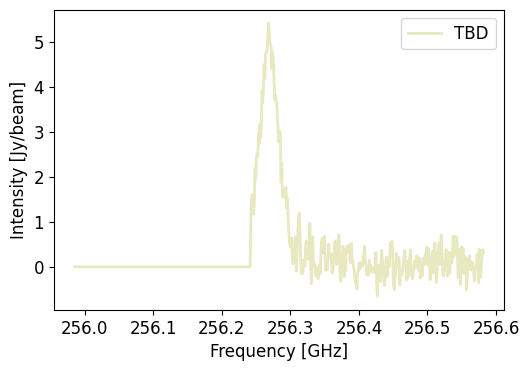

In [21]:
############ Major flow of data analysis ###############################

## Open FITS image cube
fitscubename = '/home/tcc/DATA/GC_Dspecies/ancillary/H29alpha_7m+12m_natural.image.fits'
myAnalysis = spectraAna(fitscubename = fitscubename)
myAnalysis.readfits(verbose = False)

naxis3     = myAnalysis.naxis3
crpix3     = myAnalysis.crpix3
cdelt3     = myAnalysis.cdelt3
crval3     = myAnalysis.crval3 
freq_array = np.zeros( naxis3 )
freq_array = crval3 + ( np.arange(naxis3) + 1 - crpix3 ) * cdelt3


## Choose the intensity arrays without nan 
intensity_list = []
for xpix in range(420,425):
    for ypix in range(510,525):
        intensity_array = myAnalysis.Ihdu[0].data[0][:, ypix, xpix]
        
        #plot_spectra( 
        #              freq_array/1e9, 
        #              intensity_array, 
        #              datalabel = f'({xpix + 1},{ypix + 1})' 
        #            )
        
        
        
        if not np.any( np.isnan(intensity_array) ):
            
            intensity_list.append(intensity_array)


## To do the gaussian fitting and unredshift/unblueshift
filename = 'gaussian_err.log'
os.system('rm -rf '+ filename)
with open(filename,'w') as f:

    for intensity_array in intensity_list:
        
        try:
            fit_1dgaus( freq_array/1e9, intensity_array , plot=False)
            
        except:
            outstring = f'Pixels (i,j)= ({xpix},{ypix})' + ' failed in Gaussian fittings'
            f.write(out_string)
                
    f.close()

shift_freq = unredblueshift_spectra(freq_array)

## stack the spectrum with all pixels and plot it
stack_intensity = np.sum(intensity_list,axis=0)
plot_spectra(shift_freq/1e9, stack_intensity, 
             outPDF_filename='stacked_spectra.pdf')

In [ ]:
############ Major flow of data analysis ###############################

## Open FITS image cube
fitscubename = '/home/tcc/DATA/GC_Dspecies/ancillary/H29alpha_7m+12m_natural.image.fits'
myAnalysis = spectraAna(fitscubename = fitscubename)
myAnalysis.readfits(verbose = False)
ypix = 523
xpix = 425
intensity_array =  myAnalysis.Ihdu[0].data[0][:, ypix, xpix]

naxis3     = myAnalysis.naxis3
crpix3     = myAnalysis.crpix3
cdelt3     = myAnalysis.cdelt3
crval3     = myAnalysis.crval3 
freq_array = np.zeros( naxis3 )
freq_array = crval3 + ( np.arange(naxis3) + 1 - crpix3 ) * cdelt3

plot_spectra( freq_array/1e9, intensity_array )

## Loop over all spatial pixels and fit the centroid velocity
#myAnalysis.get_velocity(verbose = False)

## Based on the 2D centroid-velocity map to un-redshift/blueshift spectra
#myAnalysis.unrbshift_spectra(verbose = False)

## stack spectra
#myAnalysis.stack_spectra()


In [ ]:
test   =  np.array( range(10) )
test1  =  np.array( range(10)  ) + 5.0
test2 =  test1[ test > 4 ]
print(test2)

In [ ]:
# https://splatalogue.online//
CI_restfreq = 492.16065100          # GHz
HCOplus3to2_restfreq = 267.55762590 # GHz

In [ ]:
# Open FITS image cube
fitscubename = '/home/tcc/DATA/GC_Dspecies/ancillary/H29alpha_7m+12m_natural.image.fits'
myAnalysis = spectraAna(fitscubename = fitscubename)
myAnalysis.readfits(verbose = True)
ypix = 495
xpix = 425
intensity_array =  myAnalysis.Ihdu[0].data[0][:, ypix, xpix]


naxis3     = myAnalysis.naxis3
crpix3     = myAnalysis.crpix3
cdelt3     = myAnalysis.cdelt3
crval3     = myAnalysis.crval3 
freq_array = np.zeros( naxis3 )
freq_array = crval3 + ( np.arange(naxis3) + 1 - crpix3 ) * cdelt3

print(np.shape(freq_array))


freqGHz_start = 256.57
freqGHz_end   = 256.27

freq_startpix = round( ( freqGHz_start*1e9 - crval3 )/cdelt3 + crpix3 )
freq_endpix = round( ( freqGHz_end*1e9 - crval3 )/cdelt3 + crpix3 )

print(freq_startpix, freq_endpix)

# print(freq_array)
plot_spectra( freq_array[freq_startpix:freq_endpix]/1e9, intensity_array[freq_startpix:freq_endpix])


In [ ]:
## calculate the standard deviation as measurement errors (y_err)
std = np.std(intensity_array[freq_startpix:freq_endpix])
print(std)

In [ ]:
filename = 'gaussian_err.log'

# remove the file in case it exist
os.system('rm -rf '+ filename)

# open output file
f = open(filename, "w")

for i in range(0, naxis1):
    for j in range(0, naxis2):
        
        
        freq_array = freq_array
        data       = spectrum[j][i]
        
        try: 
            popt, perr = curfit(freq_array, data, gaus1d)
        except:
            outstring = 'Pixels i:' + str(i) + ' j:' + str(j) + ' failed in Gaussian fittings'
            f.write(out_string)
            
f.close()

In [ ]:
try:
    a = [0,1,2]
    print(a[4])
except:
    print('does not make sense')